# Baseline Models

## Objective

The objective of this notebook is to train and evaluate supervised learning models for spam detection. 

Two baseline classiffiers are compared under the same dataset.<br>
- Logistic Regression<br>
- Multinomial Naive Bayes<br>

Evaluation focuses on metrics suitable for class imbalanced classification:<br>
- Precision;<br>
- Recall;<br>
- F1-Score;<br>
- Confusion Matrix;<br>
- ROC-AUC.<br>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay
)

import matplotlib.pyplot as plt


## Data Loading

The preprocessed dataset produced in the previous nothebook is loaded.<br>
The modelling stage uses:<br>
- "clean_message", as the input text;<br>
- "label_encoded", as the target variable (0 -> ham, 1 -> spam).

In [2]:
data_path = "../datasets/processed/sms_spam_preprocessed.csv"
df = pd.read_csv(data_path)

#df.head()
df[["label_encoded", "clean_message"]].head()

,label_encoded,clean_message
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in a wkly comp to win fa cup final...
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...


## Data Sanity Checks

Basic check to ensure dataset contains valid text and labels.

In [3]:
df["clean_message"].isnull().sum(), df["label_encoded"].isnull().sum()
df["label_encoded"].value_counts()

label_encoded
0    4516
1     653
Name: count, dtype: int64

## Train / Test Split

Was used a specific split, a random seed is applied to ensure reproducibility. 

In [4]:
df = df.dropna(subset=["clean_message"])
df = df[df["clean_message"].str.strip() != ""]

df["clean_message"].isnull().sum(), (df["clean_message"].str.strip() == "").sum()


(0, 0)

In [5]:
x = df["clean_message"]
y = df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


(label_encoded
 0    0.873669
 1    0.126331
 Name: proportion, dtype: float64,
 label_encoded
 0    0.873308
 1    0.126692
 Name: proportion, dtype: float64)

A train / test split of 80/20 is used in this project. This ratio provides a good balance between training data, and a suficient large test set.

## Feature Extraction (TF-IDF)

Used TF-IDF to convert text into a sparse numerical representation. This is a standard approach for spam detection task. This method downweight comon words like "the" and highlight unique words like "free", and concatenated words like "free prize".


In [6]:
tfidf = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((4132, 5056), (1034, 5056))

TF-IDF was used to convert SMS messages into numerical feature vectors by weighting
words according to their importance within individual messages and their rarity
across the entire dataset.

## Baseline Models

Two models are trained using the same TF-IDF features:<br>
1. <strong>Logistic Regression</strong>
2. <strong>Multinomial Naive Bayes</strong>


### Train Models

In [7]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ),
    "Multinomial Naive Bayes": MultinomialNB()
}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)

print("Models trained.")

Models trained.


### Evaluate Models

In [ ]:
def evaluate_model(model, X_test_vec, y_test, model_name):
    y_pred = model.predict(X_test_vec)

    print(f"\n=== {model_name} ===")
    print(classification_report(
        y_test, y_pred, 
        target_names=["ham", "spam"]
    ))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
    disp.plot()
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # both Logistic Regression and Multinomial Naive Bayes support predict_proba, this if else here is to support other models like SVM that don't support it.
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_vec)[:, 1]
        auc = roc_auc_score(y_test, y_score)
        print(f"ROC-AUC: {auc:.4f}")

        RocCurveDisplay.from_predictions(y_test, y_score)
        plt.title(f"ROC Curve - {model_name}")
        plt.show()
    else:
        print("ROC-AUC not available (no predict_proba).")


=== Logistic Regression ===
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       903
        spam       0.91      0.91      0.91       131

    accuracy                           0.98      1034
   macro avg       0.95      0.95      0.95      1034
weighted avg       0.98      0.98      0.98      1034



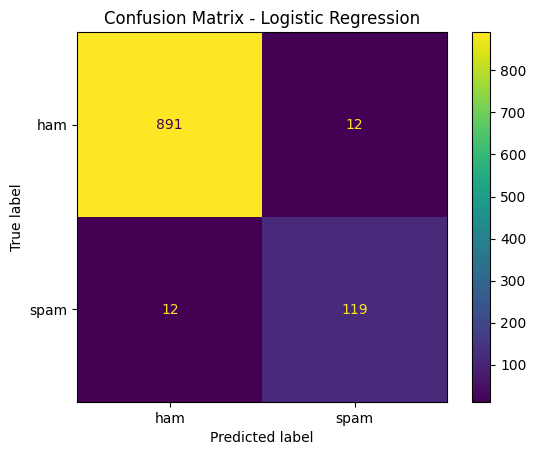

ROC-AUC: 0.9908


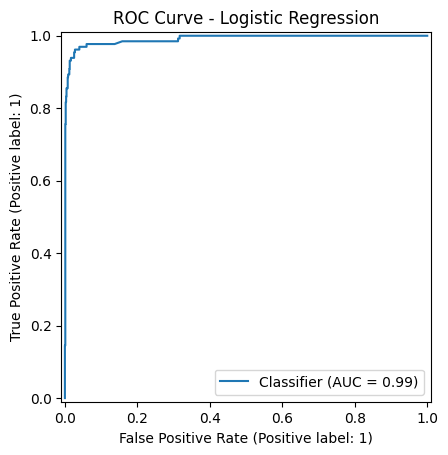


=== Multinomial Naive Bayes ===
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       903
        spam       1.00      0.76      0.87       131

    accuracy                           0.97      1034
   macro avg       0.98      0.88      0.92      1034
weighted avg       0.97      0.97      0.97      1034



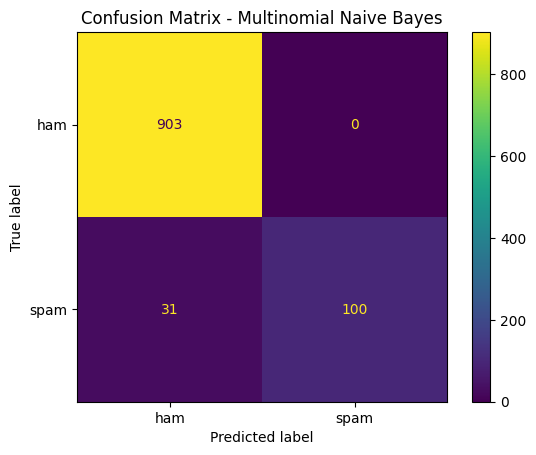

ROC-AUC: 0.9786


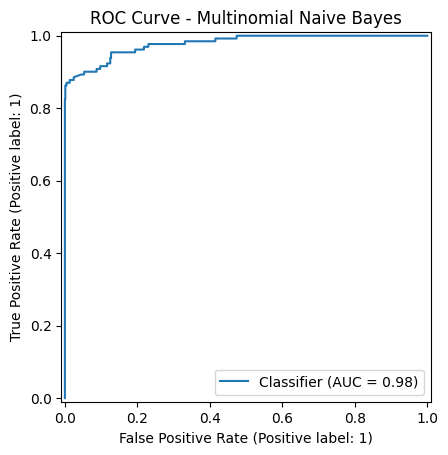

In [9]:
for name, model in models.items():
    evaluate_model(model, X_test_tfidf, y_test, name)